In [1]:
import datetime as dt
import difflib
import json
import math
import os
import string
import sys
from datetime import timedelta
from random import sample

import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pyreadstat
import seaborn as sns
import statsmodels.tools.tools as sm
import statsmodels.base as sb
from folium.features import CustomIcon
from folium.plugins import FastMarkerCluster, HeatMap, MarkerCluster
from linearmodels.panel.model import PooledOLS
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import aic, rmse
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from yahoofinancials import YahooFinancials
import pickle
import array_to_latex as a2l
import markdown
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import pdfkit as pdf


import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.signal import savgol_filter

In [2]:
data = pd.read_csv(
    "./markettrends0.csv",
    dtype={
        "state": "str",
        "sa3_name16": "str",
        "sa4_name16": "str",
        "postcode": "str",
        "state": "str",
        "property_type": "str",
    },
)
ndata = data.fillna(
    {"Volume of new rental listings (1 month)": 0, "Volume of sales (1 month)": 0}
).dropna(subset=["postcode"])
ndatahouses = ndata[:][ndata.property_type == "Houses"]
ndataunits = ndata[:][ndata.property_type == "Units"]

In [3]:
UniqueNames_sa4 = ndatahouses.sa4_name16.unique()[:-1]

In [4]:
# with open('DataFrameDict_postcode.pickle', 'wb') as f:
#     pickle.dump(DataFrameDict_postcode, f)
with open('DataFrameDict_postcode.pickle', 'rb') as f:
     DataFrameDict_postcode =  pickle.load(f)    

In [5]:
aveHPI_lv3 = []
lst = ["postcode", "sa4", "state", "logHPI", "logHPIdiff"]
# Calling DataFrame constructor on list
for key in DataFrameDict_postcode.keys():
    df = pd.DataFrame([], columns=lst)
    df["Description"] = DataFrameDict_postcode[key]["value_at_date"].loc[
        ("2020-01" > DataFrameDict_postcode[key]["value_at_date"])
        & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
    ]
    df["logHPI"] =np.log2(
        DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
            ("2020-01" > DataFrameDict_postcode[key]["value_at_date"])
            & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
        ]
    )
    df["postcode"] = key
    df["sa4"] = DataFrameDict_postcode[key]["sa4_name16"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    df["state"] = DataFrameDict_postcode[key]["state"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    
    df["logHPIdiff"] = df["logHPI"].diff(1)
    aveHPI_lv3.append(df)

aveHPIdf_lv3 = pd.concat(aveHPI_lv3)
aveHPIdf_lv3 = aveHPIdf_lv3.reset_index(drop=True)
aveHPIdf_lv3['date'] = pd.to_datetime(aveHPIdf_lv3['Description'],errors = 'coerce')
aveHPIdf_lv3['year'] = pd.DatetimeIndex(aveHPIdf_lv3['date']).year



In [6]:
def person_cat(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDAp[key][lst1]
            .loc[DataFrameDict_HILDAp[key]["hhpcode"] == postcode]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def house_cat(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDA[key][lst1]
            .loc[DataFrameDict_HILDA[key]["hhpcode"] == postcode]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def person_num(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDAp[key][lst1].loc[
            DataFrameDict_HILDAp[key]["hhpcode"] == postcode
        ]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def house_num(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDA[key][lst1].loc[
            DataFrameDict_HILDA[key]["hhpcode"] == postcode
        ]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def HILDAext_cat(postcode, lst1, lst2):
    dfHILDA1 = house_cat(postcode, lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_cat(postcode, lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
def HILDAext_num(postcode, lst1, lst2):
    dfHILDA1 = house_num(postcode, lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_num(postcode, lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)
lst_age = [f'hgdob{i}' for i in range(1, 21)]

def HILDAext_age(postcode):    
    df_tmp = pd.DataFrame()
    for key in DataFrameDict_HILDA.keys():
        df = DataFrameDict_HILDA[key][lst_age].loc[DataFrameDict_HILDA[key]["hhpcode"] == postcode]
        df["date"] = str(key)
        df = df.melt(id_vars='date', var_name='Indicator name', value_name='birth_date').sort_values('date', ascending=False).reset_index(drop=True)
        df['birthDate'] = pd.to_datetime(df['birth_date'].replace(r'-','na',regex=True),errors = 'coerce')
        df['year'] = pd.DatetimeIndex(df['birthDate']).year
        df['age'] = key +1 - df['year']
        df_tmp = pd.concat([df_tmp, df[['date','age']]], axis=0, ignore_index=True)
    f = {'age': ['median', 'std', q1, q3,'count']} 
    dfHILDAage = df_tmp.groupby('date').agg(f)
    dfHILDAage = dfHILDAage.set_axis(dfHILDAage.columns.map(''.join), axis=1, inplace=False).reset_index()
    dfHILDAage["date"] = pd.to_datetime(dfHILDAage["date"]) + pd.offsets.YearEnd()
    return dfHILDAage




In [7]:
import re


def nan_dum(df):
    df1_ohe = df
    nan_df = df1_ohe.loc[:, df1_ohe.columns.str.endswith("_nan")]
    pattern = "^([^_]*)_"
    regex = re.compile(pattern)
    for index in df1_ohe.index:
        for col_nan in nan_df.columns:
            if df1_ohe.loc[index, col_nan] == 1:
                col_id = regex.search(col_nan).group(1)
                targets = df1_ohe.columns[df1_ohe.columns.str.startswith(col_id + "_")]
                df1_ohe.loc[index, targets] = np.nan
    df1_ohe.drop(
        df1_ohe.columns[df1_ohe.columns.str.endswith("_nan")], axis=1, inplace=True
    )
    return df1_ohe

In [8]:
varnames_catp = ["ancob", "edhigh1", "anatsi", "chkb12", "sex"]
# varnames_nump = ["wsce", "baynoa"]
varnames_nump = ["wsce"]
varnames_cath = []
#varnames_cath = ["xpgroci"]
varnames_numh = ["hsdebt"]

# UniqueNames_Hsa4 = avg_3.sa4.unique()[:-1]
# DataFrameDict_Hsa4 = {elem: pd.DataFrame for elem in UniqueNames_Hsa4}

# for key in DataFrameDict_Hsa4.keys():
#     lstpcCL= ndatahouses['postcode'].loc[ndatahouses['sa4_name16'] == key].unique()
#     lst0 = list(set(lstpcCL) - set(HILDAallpc))
#     lstpc  = list(set(lstpcCL) - set(lst0))
#     df_tmp = pd.DataFrame([])
#     for key_pc in lstpc:
#         HILDAextract_num = HILDAext_num(key_pc, varnames_numh, varnames_nump)
#         HILDAextract_cat = HILDAext_cat(key_pc, varnames_cath, varnames_catp)
#         HILDAextract_age = HILDAext_age(key_pc)
#         HILDAextract = pd.merge(HILDAextract_num, HILDAextract_cat, on="date", how="left")
#         HILDAextract = pd.merge( HILDAextract , HILDAextract_age, on="date", how="left")
#         df_tmp = pd.concat([df_tmp, HILDAextract], axis=0, ignore_index=True)
#     dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=True)})
#     list1, list2 = zip(*dfHILDA.columns)
#     dfHILDA.columns = list1
#     DataFrameDict_Hsa4[key] = dfHILDA.reset_index()    

In [9]:
with open('DataFrameDict_Hsa4.pickle', 'rb') as f:
    DataFrameDict_Hsa4 =  pickle.load(f)

In [10]:
def HILDA2PCsa4(key, marks):
    df = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    
    vrst = pd.DataFrame([])
    for vn in df1.columns.values[1:]:
        vrst = pd.concat([vrst, selectStationaySeries3(df1[vn], vn, marks)], axis=1)
    vrdata = vrst.reset_index()
    
    pca = PCA()
    X_train = vrdata.loc[:, vrdata.columns != "date"]
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.9) + 1
    print(d)

    pca_d = PCA(n_components=d)
    pca_d.fit(X_train_std)
    X_pca_d = pca_d.transform(X_train_std)
    PCnames = []
    for i in range(1, d + 1, 1):
        PCnames.append(f"sa4PC{i}")
    pcadf = pd.DataFrame(X_pca_d, columns=PCnames)
    pcadf['date'] = DataFrameDict_Hsa4[key]['date']  
    pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
    pcadf["date"] = pcadf["date"]
    return pcadf

In [11]:
def HILDAvarExt(key, marks):
    df = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    vrst = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list( set(df_marks['Variable Names'].values) & set(df1.columns.values[1:]))
    for vn in lst:
        vrst[vn] = selectStationaySeries3(df1[vn], vn, marks)
    vrdata = vrst.reset_index().fillna(value = 0) 
    return(vrdata)

In [12]:
def PCA_val(gamma1,marks,vrdata):
    tmp = pd.DataFrame([], columns = marks['Variable Names'].values)
    for key in DataFrameDict_Hsa4.keys(): 
        df = HILDAvarExt(key,marks)
        df1= df[vrdata.columns.tolist()]
        df2 = df1.drop(df1.columns[0], axis=1)
        
        vrdata1 = vrdata.drop(vrdata.columns[0],axis=1)
        vrdata2= vrdata1.apply(lambda x: x*gamma1)
        
        df_add = df2.add(vrdata2, fill_value=0)
        tmp = pd.concat([tmp, df_add],axis = 0)
        
    pca = PCA()
    X_train = tmp
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d2 = np.argmax(cumsum >= 0.9) + 1


    pca_d_sa4 = PCA(n_components=d2)
    pca_d_sa4.fit(X_train_std)
    X_pca_d_sa4 = pca_d_sa4.transform(X_train_std)

    PCnames = []
    for i in range(1, d2 + 1, 1):
        PCnames.append(f"sa4PC{i}")
    
    pcadf = pd.DataFrame(X_pca_d_sa4, columns=PCnames)
    pcadf_sa4_date = pcadf
    return  d2, pca_d_sa4

In [13]:
def person_cat_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDAp[key][lst1]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def house_cat_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDA[key][lst1].astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def person_num_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDAp[key][lst1]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def house_num_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDA[key][lst1]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def HILDAext_cat_all(lst1, lst2):
    dfHILDA1 = house_cat_all( lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_cat_all(lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
def HILDAext_num_all( lst1, lst2):
    dfHILDA1 = house_num_all(lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_num_all(lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
lst_age = [f'hgdob{i}' for i in range(1, 21)]
def HILDAext_age_all():    
    df_tmp = pd.DataFrame()
    for key in DataFrameDict_HILDA.keys():
        df = DataFrameDict_HILDA[key][lst_age]
        df["date"] = str(key)
        df = df.melt(id_vars='date', var_name='Indicator name', value_name='birth_date').sort_values('date', ascending=False).reset_index(drop=True)
        df['birthDate'] = pd.to_datetime(df['birth_date'].replace(r'-','na',regex=True),errors = 'coerce')
        df['year'] = pd.DatetimeIndex(df['birthDate']).year
        df['age'] = key +1 - df['year']
        df_tmp = pd.concat([df_tmp, df[['date','age']]], axis=0, ignore_index=True)
    f = {'age': ['median', 'std', q1, q3,'count']} 
    dfHILDAage = df_tmp.groupby('date').agg(f)
    dfHILDAage = dfHILDAage.set_axis(dfHILDAage.columns.map(''.join), axis=1, inplace=False).reset_index()
    dfHILDAage["date"] = pd.to_datetime(dfHILDAage["date"]) + pd.offsets.YearEnd()
    return dfHILDAage

In [14]:
# with open('dfHILDA_cut.pickle', 'wb') as f:
#     pickle.dump(dfHILDA_cut, f)
with open('dfHILDA_cut.pickle', 'rb') as f:
      dfHILDA_cut =  pickle.load(f)    

In [15]:
with open('dfHILDA.pickle', 'rb') as f:
      dfHILDA =  pickle.load(f)    

In [16]:
threshold = 0.01
df = dfHILDA_cut.set_index("date")
df1 = df.resample("Y").mean().iloc[:, :]
vrst = pd.DataFrame([])

# need a dataframe to writedown the way to stabilize all variables
df_marks = pd.DataFrame([],
                   columns=['Variable Names', 'Approach'])


for vn in df1.columns.values[1:]:
    
    variable_tar = df1[vn]
    
    count1 = np.isinf(variable_tar.pct_change(1)).values.sum()
    count2 = np.isinf(variable_tar.pct_change(1)).values.sum()
    
    if adfuller(variable_tar.interpolate("bfill").interpolate("ffill"))[1] < threshold:
            stationary_variable = variable_tar.interpolate("bfill").interpolate("ffill")
            suffix =  "original"
            new_row = {'Variable Names': vn,'Approach': suffix}
            df_marks = df_marks.append(new_row, ignore_index=True)
            newseries = pd.DataFrame(stationary_variable)
            vrst = pd.concat([vrst, newseries], axis=1)

    
    
    elif count1 == 0:
        try:
            if adfuller(variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill")
                suffix = "1storderdiff"
                new_row = {'Variable Names': vn,'Approach': suffix}
                df_marks = df_marks.append(new_row, ignore_index=True)
                newseries = pd.DataFrame(stationary_variable)
                vrst = pd.concat([vrst, newseries], axis=1)

        except np.linalg.LinAlgError as e1:
            print('except:', e1)
    
    
    elif count2 == 0:
        try: 
            if adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
                suffix = "2ndorderdiff"
                new_row = {'Variable Names': vn,'Approach': suffix}
                df_marks = df_marks.append(new_row, ignore_index=True)
                newseries = pd.DataFrame(stationary_variable)
                vrst = pd.concat([vrst, newseries], axis=1)

        except np.linalg.LinAlgError as e1:
            print('except:', e1)     
    
    else:
        print('not found')

    
    
vrdata = vrst.reset_index()
    
pca = PCA()
X_train = vrdata.loc[:, vrdata.columns != "date"]
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

pca.fit(X_train_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d2 = np.argmax(cumsum >= 0.9) + 1
print(d2)

pca_d_sa4 = PCA(n_components=d2)
pca_d_sa4.fit(X_train_std)
X_pca_d_sa4 = pca_d_sa4.transform(X_train_std)

PCnames = []
for i in range(1, d2 + 1, 1):
    PCnames.append(f"sa4PC{i}")
    
pcadf = pd.DataFrame(X_pca_d_sa4, columns=PCnames)
pcadf['date'] = dfHILDA['date']  
pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
pcadf_sa4_date = pcadf

6


In [17]:
marks1 = df_marks['Variable Names'].loc[df_marks['Approach'] == 'original'].values
marks2 = df_marks['Variable Names'].loc[df_marks['Approach'] == "1storderdiff"].values
marks3 = df_marks['Variable Names'].loc[df_marks['Approach'] == "2ndorderdiff"].values
def selectStationaySeries3(variable_tar, vn, marks):
    
    count1 = np.isinf(variable_tar.pct_change(1)).values.sum()
    count2 = np.isinf(variable_tar.pct_change(1)).values.sum()
    marks1 =marks['Variable Names'].loc[marks['Approach'] == 'original'].values
    marks2 =marks['Variable Names'].loc[marks['Approach'] == "1storderdiff"].values
    marks3 =marks['Variable Names'].loc[marks['Approach'] == "2ndorderdiff"].values
    
    if vn in marks1:
            stationary_variable = variable_tar.interpolate("bfill").interpolate("ffill")
            suffix =  "original"
            #print(suffix)
            return(pd.DataFrame(stationary_variable))
    
    
    elif count1 == 0 and vn in marks2:
        try:
            if adfuller(variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill")
                suffix = "1storderdiff"
                #print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)
    
    
    elif count2 == 0 and vn in marks3:
        try: 
            if adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
                suffix = "2ndorderdiff"
                #print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)     

In [18]:
def HILDA2PCsa4(key, marks):
    df = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    
    vrst = pd.DataFrame([])
    for vn in df1.columns.values[1:]:
        vrst = pd.concat([vrst, selectStationaySeries3(df1[vn], vn, marks)], axis=1)
    vrdata = vrst.reset_index()
    
    pca = PCA()
    X_train = vrdata.loc[:, vrdata.columns != "date"]
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.9) + 1
    print(d)

    pca_d = PCA(n_components=d)
    pca_d.fit(X_train_std)
    X_pca_d = pca_d.transform(X_train_std)
    PCnames = []
    for i in range(1, d + 1, 1):
        PCnames.append(f"sa4PC{i}")
    pcadf = pd.DataFrame(X_pca_d, columns=PCnames)
    pcadf['date'] = DataFrameDict_Hsa4[key]['date']  
    pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
    pcadf["date"] = pcadf["date"]
    return pcadf

In [19]:
def HILDAvarExt(key, marks):
    df = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    vrst = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list( set(df_marks['Variable Names'].values) & set(df1.columns.values[1:]))
    for vn in lst:
        vrst[vn] = selectStationaySeries3(df1[vn], vn, marks)
    vrdata = vrst.reset_index().fillna(value = 0) 
    return(vrdata)


In [20]:
def PCA_val(gamma1,marks,vrdata):
    tmp = pd.DataFrame([], columns = marks['Variable Names'].values)
    for key in DataFrameDict_Hsa4.keys(): 
        df = HILDAvarExt(key,marks)
        df1= df[vrdata.columns.tolist()]
        df2 = df1.drop(df1.columns[0], axis=1)
        
        vrdata1 = vrdata.drop(vrdata.columns[0],axis=1)
        vrdata2= vrdata1.apply(lambda x: x*gamma1)
        
        df_add = df2.add(vrdata2, fill_value=0)
        tmp = pd.concat([tmp, df_add],axis = 0)
        
    pca = PCA()
    X_train = tmp
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d2 = np.argmax(cumsum >= 0.9) + 1


    pca_d_sa4 = PCA(n_components=d2)
    pca_d_sa4.fit(X_train_std)
    X_pca_d_sa4 = pca_d_sa4.transform(X_train_std)

    PCnames = []
    for i in range(1, d2 + 1, 1):
        PCnames.append(f"sa4PC{i}")
    
    pcadf = pd.DataFrame(X_pca_d_sa4, columns=PCnames)
    pcadf_sa4_date = pcadf
    return  d2, pca_d_sa4

In [21]:
PCnumbers = []
x = range(0,100,1)
for gamma in x:
    gamma1 = gamma
    d2, pcafit = PCA_val(gamma1,df_marks,vrdata)
    PCnumbers.append(d2)
    print(gamma)

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

0


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

2


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

3


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

4


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

5


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

6


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

7


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

8


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

9


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

10


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

11


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

12


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

13


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

14


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

15


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

16


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

17


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

18


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

19


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

20


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

21


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

22


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

23


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

24


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

25


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

26


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

27


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

28


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

29


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

30


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

31


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

32


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

33


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

34


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

35


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

36


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

37


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

38


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

39


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

40


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

41


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

42


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

43


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

44


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

45


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

46


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

47


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

48


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

49


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

50


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

51


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

52


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

53


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

54


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

55


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

56


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

57


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

58


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

59


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

60


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

61


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

62


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

63


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

64


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

65


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

66


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

67


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

68


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

69


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

70


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

71


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

72


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

73


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

74


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

75


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

76


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

77


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

78


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

79


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

80


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

81


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

82


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

83


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

84


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

85


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

86


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

87


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

88


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

89


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

90


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

91


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

92


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

93


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

94


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

95


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

96


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

97


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

98


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

99


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


(array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

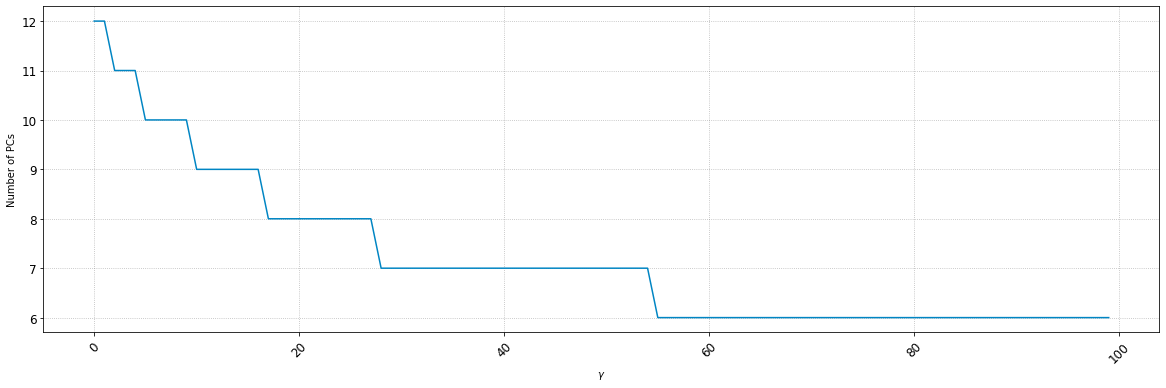

In [22]:
from scipy.interpolate import make_interp_spline, BSpline
# represents number of points to make between x.min and x.max
xnew =np.linspace(0, 100, 100)
spl = make_interp_spline(x, PCnumbers, k=1)  # type: BSpline
PCno_smooth = spl(xnew)

color1 = "#0085c3"
color2 = "#7ab800"
color3 = "#dc5034"

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
ax.plot(x, PCnumbers , color=color1)
ax.grid(ls=":", color="gray", alpha=0.6)

plt.xlabel(r'$\gamma$')
plt.ylabel('Number of PCs')


plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

In [23]:
gammaindexList = []
for i in range(12,6,-1):
   aa = min([index for index,value in enumerate(PCnumbers) if int(value)  == i])
   gammaindexList.append(aa)
gammaList = np.linspace(0, 100, 100)[gammaindexList]

In [24]:
gammaList

array([ 0.        ,  2.02020202,  5.05050505, 10.1010101 , 17.17171717,
       28.28282828])

In [25]:
pcadf['date'] = dfHILDA['date']  
pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
pcadf_sa4_date_new = pcadf


In [71]:
xls1 = pd.read_excel("f01hist.xls", sheet_name="Data", header=2)
xls1 = xls1.drop(xls1.index[0:8], axis=0)
xls1["Description"] = pd.to_datetime(xls1["Description"])
xls1["Description"] = xls1["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls3 = pd.read_excel("f11hist-1969-2009.xls", sheet_name="Data", header=2)
xls3 = xls3.drop(xls3.index[0:8], axis=0)
xls3["Description"] = pd.to_datetime(xls3["Description"])
xls3["Description"] = xls3["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls4 = pd.read_excel("f11hist.xls", sheet_name="Data", header=2)
xls4 = xls4.drop(xls4.index[0:8], axis=0)
xls4["Description"] = pd.to_datetime(xls4["Description"])
xls4["Description"] = xls4["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls34 = pd.concat([xls3, xls4], axis=0)
xls5 = pd.read_excel("g01hist.xls", sheet_name="Data", header=2)
xls5 = xls5.drop(xls5.index[0:8], axis=0)
xls5["Description"] = pd.to_datetime(xls5["Description"])
xls5["Description"] = xls5["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls6 = pd.read_excel("h01hist.xls", sheet_name="Data", header=2)
xls6 = xls6.drop(xls6.index[0:8], axis=0)
xls6["Description"] = pd.to_datetime(xls6["Description"])
xls6["Description"] = xls6["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls7 = pd.read_excel("h03hist.xls", sheet_name="Data", header=2)
xls7 = xls7.drop(xls7.index[0:8], axis=0)
xls7["Description"] = pd.to_datetime(xls7["Description"])
xls7["Description"] = xls7["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
# Download ASX data from Yahoo Finance

ASX200data = yf.download('^AXJO', start='1999-01-01', end='2021-06-01', interval = "1mo", progress=False)
ASX200data = ASX200data.reset_index()
ASX200data["Description"] = pd.to_datetime(ASX200data["Date"])
ASX200data["Description"] = ASX200data["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))

macvar = pd.DataFrame().assign(
    Description=xls7.loc[
        ("2021-06" > xls7["Description"]) & (xls7["Description"] > "1998-12")
    ]["Description"]
)
macvar.reset_index(drop=True, inplace=True)

macvar = pd.merge(
    macvar,
    xls1[["Description", "Cash Rate Target; monthly average"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls34[["Description", "AUD/USD Exchange Rate; see notes for further detail."]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls5[["Description", "Consumer price index; All groups"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls6[["Description", "Gross domestic product (GDP); Chain volume"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls7[["Description", "Retail sales; All industries; Current price"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls7[["Description", "Private dwelling approvals"]],
    on="Description",
    how="left",
)

macvar = pd.merge(
    macvar,
    ASX200data[["Description", "Adj Close"]],
    on="Description",
    how="left",
)

macvar = macvar.set_axis(
    ["date", "ir", "exr", "cpi", "gdp", "rs", "pda", "asx"], axis=1, inplace=False
)


macvar["ir"] = macvar["ir"].astype(float, errors="raise")
macvar["exr"] = macvar["exr"].astype(float, errors="raise")
macvar["cpi"] = macvar["cpi"].astype(float, errors="raise")
macvar["gdp"] = macvar["gdp"].astype(float, errors="raise")
macvar["rs"] = macvar["rs"].astype(float, errors="raise")
macvar["pda"] = macvar["pda"].astype(float, errors="raise")
macvar["asx"] = macvar["asx"].astype(float, errors="raise")
macvar = macvar.interpolate()

threshold = 0.01

def selectStationaySeries(variable_tar):
        if adfuller(variable_tar.dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar
            suffix =  "original"
        elif adfuller(variable_tar.pct_change(1).dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(1).dropna(how="all")
            suffix = "1storderdiff"
        elif adfuller(variable_tar.pct_change(3).dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(3).dropna(how="all")
            suffix = "seasonaldiff"
        elif adfuller(variable_tar.pct_change(12).dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(12).dropna(how="all")
            suffix = "annualdiff"     
        elif adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
            suffix = "2ndorderdiff"
        else:
            print("not found")
        return(pd.DataFrame(stationary_variable))
    
macvarst = macvar["date"] 
for vn in macvar.columns.values[1:]:
    macvarst = pd.concat([macvarst, selectStationaySeries(macvar[vn])], axis=1)

macvarsta = macvarst  
matrixmac = macvarsta.corr().round(2)
macdata = macvarsta.loc[
    ("2020-01" > macvarsta["date"]) & (macvarsta["date"] > "1999-12")
]

pca = PCA()
X_train = macdata.loc[:, macdata.columns != "date"]
poly= PolynomialFeatures(degree=2)
scaler = StandardScaler()

#X_train_poly = poly.fit_transform(X_train)
#X_train_std = scaler.fit_transform(X_train_poly)
X_train_std = scaler.fit_transform(X_train)

pca.fit(X_train_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1
print(d)

pca_d = PCA(n_components=d)
pca_d.fit(X_train_std)
X_pca_d = pca_d.transform(X_train_std)
PCnames = []
for i in range(1, d + 1, 1):
    PCnames.append(f"PC{i}")
PC_nat = pd.DataFrame(X_pca_d, columns=PCnames)

PC_nat['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2000-01")].reset_index(drop= True)["date"]
PC_nat= PC_nat.set_index("date")

6


In [28]:
numcols = len(X_train_std[0])
numrows = len(X_train_std)
matrixones = np.ones((numrows, numcols))
matrixdiag = np.diag(np.diag(np.ones((numcols, numcols))))

In [31]:
avg_1_y = aveHPIdf_lv3.groupby(["year"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_1_y=avg_1_y.rename(columns = {'mean':'l0'})
avg_1_y['date'] = pd.to_datetime(avg_1_y['year'].apply(str)) + pd.offsets.YearEnd()
avg_1_y = avg_1_y.set_index("date")

avg_1 = aveHPIdf_lv3.groupby(["date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_1 = avg_1.set_index("date")
avg_1=avg_1.rename(columns = {'mean':'l0'})

avg_2 = aveHPIdf_lv3.groupby(["state","year"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_2['date'] = pd.to_datetime(avg_2['year'].apply(str)) + pd.offsets.YearEnd()
avg_2 = avg_2.set_index("date")

avg_3 = aveHPIdf_lv3.groupby(["sa4","date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_3=avg_3.rename(columns = {'mean':'l01'})


avg_4 = aveHPIdf_lv3.groupby(["postcode","date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_4=avg_4.rename(columns = {'mean':'l012'})


In [87]:
agg = avg_1.reset_index()
pcadf0 = PC_nat.reset_index()
pcadf = pcadf0.loc[("2020-01" > pcadf0["date"]) & (pcadf0["date"] > "2000-11")].reset_index(drop = True)


values  = agg["l0"].loc[("2020-01" > agg["date"]) & (agg["date"] > "2000-11")].reset_index(drop=True).values
values = values.reshape((len(values), 1))

scaler1 = scaler.fit(values)
normalized  = scaler1.transform(values)
normalized_list =  [i[0] for i in normalized]
normalized_df = pd.DataFrame(normalized_list,columns = ['l0'])

pca_avg = pd.concat(
    [
        pcadf,
        normalized_df,
    ],
    axis=1,
)


df = pca_avg.iloc[:,1:]
model = VAR(df)
print(model.select_order(12).summary() )
# lag order should be one here

model_fitted = model.fit(2)
model_fitted.summary()
model_fitted_l0 =  model_fitted


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)


for col, val in zip(df.columns, out):
    print(col, ":", round(val, 2))

lag_order = model_fitted.k_ar
forecast_input = df
start_point = lag_order 

df_forecast = []
for i in range(1,df.shape[0]-lag_order+1, 1):
    forecast_input = df.values[
        -lag_order + start_point + i - 1 : start_point + i - 1,
    ]
    df_forecast.append(
        model_fitted.forecast(y=forecast_input, steps=1)[
            0,
        ][-1]
    )
    
values_forecast = np.array(df_forecast)
values_forecast = values_forecast.reshape((len(values_forecast), 1))
inversed = scaler1.inverse_transform(values_forecast)
inversed_list =  [i[0] for i in inversed]

lag_order_l0 = lag_order
start_point_l0 =  start_point

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -1.447      -1.339      0.2352      -1.404
1       -3.836     -2.967*     0.02158     -3.485*
2       -3.989      -2.359     0.01855      -3.331
3      -4.211*      -1.820    0.01491*      -3.245
4       -4.021     -0.8691     0.01814      -2.748
5       -3.879     0.03323     0.02112      -2.299
6       -3.962      0.7110     0.01973      -2.075
7       -3.837       1.597     0.02285      -1.642
8       -3.726       2.468     0.02627      -1.224
9       -3.745       3.210     0.02676     -0.9360
10      -3.597       4.119     0.03257     -0.4800
11      -3.526       4.951     0.03710     -0.1022
12      -3.432       5.806     0.04387      0.2996
--------------------------------------------------
PC1 : 2.02
PC2 : 2.02
PC3 : 2.15
PC4 : 1.95
PC5 : 1.94
PC6 : 1.94
l0 : 2.06


In [34]:
print(model_fitted.coefs[0][-1])
print(model_fitted.coefs[1][-1])

[-0.07930084 -0.00596552 -0.00939999  0.03627496 -0.02212942 -0.0484252
  1.16447842]
[ 0.00149105  0.00367227  0.03482678 -0.00773899  0.01285884 -0.08986178
 -0.25178463]


In [165]:
df = pca_avg.iloc[:,1:]
nobs = 28  # post-covid data is used as the test data set
df_train, df_test = df[0:-nobs], df[-nobs:]
# Check size

start_point = df_train.shape[0]
lag_order = model_fitted_l0.k_ar
forecast_input = df_train.values[-lag_order:]

df_forecast = []
for i in range(1, nobs + 1, 1):
    forecast_input = df.values[-lag_order + start_point + i - 1 : start_point + i - 1,]
    df_forecast.append(
        model_fitted_l0.forecast(y=forecast_input, steps=1)[
            0,
        ][-1]
    )

values_forecast = np.array(df_forecast)
values_forecast = values_forecast.reshape((len(values_forecast), 1))
inversed = scaler1.inverse_transform(values_forecast)
inversed_list =  [i[0] for i in inversed]
y = inversed_list



In [190]:
date_frame = pd.DataFrame(agg["date"].loc[("2020-01" > agg["date"]) & (agg["date"] > "2001-01")].reset_index(drop=True))
x = date_frame[-nobs:]["date"]
df_plot = pd.DataFrame({'date':x, 'l0_pred':y })
y2 = agg["l0"].loc[("2020-01" > agg["date"]) & (agg["date"] > "2000-11")].reset_index(drop=True)[-nobs:]
df_plot['l0'] = agg['l0'].loc[("2020-01" > agg["date"]) & (agg["date"] > "2000-11")][-nobs:].values
df_plot = df_plot.set_index('date',drop = True)

In [110]:
# df_results = pd.DataFrame(df_forecast, index=df.index[-nobs:], columns=["forecast"])

# forecast_input_lt = df_train.values[-lag_order:]
# fc = model_fitted.forecast(y=forecast_input_lt, steps=nobs)

# df_results_lt = pd.DataFrame(
#     fc, index=df.index[-nobs:], columns=df.columns + "forecast"
# )

In [272]:
sim_times = 100 
mu, sigma = 0, 1 
df = pca_avg.iloc[:,1:]
model_fitted = model_fitted_l0
lag_order = lag_order_l0
start_point = start_point_l0


DF_simResults_l0 = pd.DataFrame({}, columns = ['l0'])
DF_simResults_PC1 = pd.DataFrame({}, columns = ['PC1'])
DF_simResults_PC2 = pd.DataFrame({}, columns = ['PC2'])
DF_simResults_PC3 = pd.DataFrame({}, columns = ['PC3'])
DF_simResults_PC4 = pd.DataFrame({}, columns = ['PC4'])
DF_simResults_PC5 = pd.DataFrame({}, columns = ['PC5'])
DF_simResults_PC6 = pd.DataFrame({}, columns = ['PC6'])

for t in range(1, sim_times):
    df_forecast_sim = pd.DataFrame({},columns=df.columns)
    df_forecast_sim = df_forecast_sim.append(pca_avg.iloc[ -2:,1: ]).reset_index(drop = True)
    for i in range(1,60, 1):
        forecast_input = df_forecast_sim.values[-lag_order + start_point + i - 1 : start_point + i - 1,]
        arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
        arr_noise = np.random.normal(mu, sigma, len(df.columns))
        arr_new = np.add(arr_pred,arr_noise)
        df_new =  pd.DataFrame( arr_new ,columns=df.columns )
        df_forecast_sim = df_forecast_sim.append(df_new)
        df_forecast_sim = df_forecast_sim.reset_index(drop = True)
    DF_simResults_l0 = DF_simResults_l0.join(df_forecast_sim['l0'], how='right', rsuffix = f'_sim{t}')
    DF_simResults_PC1 = DF_simResults_PC1.join(df_forecast_sim['PC1'], how='right', rsuffix = f'_sim{t}')
    DF_simResults_PC2 = DF_simResults_PC2.join(df_forecast_sim['PC2'], how='right', rsuffix = f'_sim{t}')
    DF_simResults_PC3 = DF_simResults_PC3.join(df_forecast_sim['PC3'], how='right', rsuffix = f'_sim{t}')
    DF_simResults_PC4 = DF_simResults_PC4.join(df_forecast_sim['PC4'], how='right', rsuffix = f'_sim{t}')
    DF_simResults_PC5 = DF_simResults_PC5.join(df_forecast_sim['PC5'], how='right', rsuffix = f'_sim{t}')
    DF_simResults_PC6 = DF_simResults_PC6.join(df_forecast_sim['PC6'], how='right', rsuffix = f'_sim{t}')
    
DF_simResults_l0['date'] = pd.date_range('2019-11-30', periods=61, freq='M') 
DF_simResults_l0.set_index("date", inplace = True)
DF_simResults_l0.drop(labels='l0', axis=1, inplace=True)

DF_simResults_l0 = pd.DataFrame(scaler1.inverse_transform(DF_simResults_l0.values), index = DF_simResults_l0.index, columns =   DF_simResults_l0.columns)


/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_34749/4067471145.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  DF_simResults_l0['date'] = pd.date_range('2019-11-30', periods=61, freq='M')


In [245]:
DF_simResults_l0

,l0_sim1,l0_sim2,l0_sim3,l0_sim4,l0_sim5,l0_sim6,l0_sim7,l0_sim8,l0_sim9,l0_sim10,...,l0_sim90,l0_sim91,l0_sim92,l0_sim93,l0_sim94,l0_sim95,l0_sim96,l0_sim97,l0_sim98,l0_sim99
date,,,,,,,,,,,,,,,,,,,,,
2019-11-30,0.017664,0.017664,0.017664,0.017664,0.017664,0.017664,0.017664,0.017664,0.017664,0.017664,...,0.017664,0.017664,0.017664,0.017664,0.017664,0.017664,0.017664,0.017664,0.017664,0.017664
2019-12-31,0.014028,0.014028,0.014028,0.014028,0.014028,0.014028,0.014028,0.014028,0.014028,0.014028,...,0.014028,0.014028,0.014028,0.014028,0.014028,0.014028,0.014028,0.014028,0.014028,0.014028
2020-01-31,0.006525,0.011300,0.011631,0.009598,0.021338,0.011619,-0.001382,0.011866,0.010472,0.012930,...,0.006337,0.001370,0.014863,0.007488,0.012124,0.014208,0.024168,0.015177,0.021652,0.023550
2020-02-29,-0.002209,0.019881,0.008646,-0.004879,0.020855,0.007762,0.014041,0.016188,0.009635,0.014638,...,0.016791,0.005896,0.003105,0.008729,0.027755,0.020873,0.038169,0.014377,0.035357,0.019516
2020-03-31,-0.019665,0.010570,-0.007474,-0.003325,0.020744,-0.004547,0.037070,0.018923,0.009803,0.008393,...,0.018068,0.014975,-0.009512,0.006564,0.044628,0.025062,0.045546,0.016350,0.032514,0.027221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31,-0.027800,-0.027215,0.045642,0.005736,0.026189,-0.019832,-0.013719,-0.026941,0.050931,-0.045210,...,0.007392,0.002520,0.046232,-0.039822,-0.040954,-0.018918,0.017892,-0.033160,0.023887,0.051304
2024-08-31,-0.029650,-0.021679,0.032653,-0.004913,0.020388,-0.025957,-0.006753,-0.028341,0.060021,-0.029579,...,0.020074,-0.003701,0.038269,-0.029026,-0.027219,-0.031568,0.019919,-0.038631,0.034063,0.038621
2024-09-30,-0.016719,-0.017894,0.016831,-0.026316,0.045899,-0.021507,0.012495,-0.024277,0.058978,-0.036419,...,0.020153,-0.007804,0.015275,-0.026388,-0.020166,-0.043125,0.021829,-0.041148,0.035626,0.022051


In [259]:
sim_res_example =  DF_simResults_l0[1:]
sim_res_example['mean'] =  sim_res_example.mean(axis = 1)
sim_res_example['stdev'] = sim_res_example.std(axis=1)
sim_res_example['moe'] = z_critical * (sim_res_example['stdev']/math.sqrt(sim_times))
sim_res_example['Ubound'] = sim_res_example.quantile(0.975,axis = 1)
sim_res_example['Lbound'] = sim_res_example.quantile(0.025,axis = 1)
sim_res_example['Ubound2'] = sim_res_example.quantile(0.84,axis = 1)
sim_res_example['Lbound2'] = sim_res_example.quantile(0.16,axis = 1)

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [260]:
df_plot1 = pd.concat([df_plot, sim_res_example], axis=1)
df_plot2 = df_plot1.reset_index()
df_plot2

,date,l0_pred,l0,l0_sim1,l0_sim2,l0_sim3,l0_sim4,l0_sim5,l0_sim6,l0_sim7,...,l0_sim97,l0_sim98,l0_sim99,mean,stdev,moe,Ubound,Lbound,Ubound2,Lbound2
0,2017-09-30,0.000465,0.002712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-10-31,0.003130,0.004346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-11-30,0.005397,0.003347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-12-31,0.004092,-0.000688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-31,0.000055,0.000998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2024-07-31,NaN,NaN,-0.027800,-0.027215,0.045642,0.005736,0.026189,-0.019832,-0.013719,...,-0.033160,0.023887,0.051304,0.005637,0.027146,0.004465,0.051191,-0.042849,0.033006,-0.023698
83,2024-08-31,NaN,NaN,-0.029650,-0.021679,0.032653,-0.004913,0.020388,-0.025957,-0.006753,...,-0.038631,0.034063,0.038621,0.006874,0.027800,0.004573,0.059351,-0.044387,0.034936,-0.026195
84,2024-09-30,NaN,NaN,-0.016719,-0.017894,0.016831,-0.026316,0.045899,-0.021507,0.012495,...,-0.041148,0.035626,0.022051,0.007869,0.027494,0.004522,0.057543,-0.042500,0.035126,-0.021099
85,2024-10-31,NaN,NaN,-0.005647,-0.000951,0.014547,-0.035734,0.058631,-0.015934,0.011176,...,-0.030433,0.033897,0.020727,0.006948,0.028670,0.004716,0.056979,-0.046731,0.033847,-0.021788


In [261]:
# sim_times = 1000
# mu, sigma = 0, 1 
# df = pca_avg.iloc[:,1:]
# model_fitted = model_fitted_l0
# lag_order = lag_order_l0
# start_point = start_point_l0


# DF_simResults_l0 = pd.DataFrame({}, columns = ['l0'])

# for t in range(1, sim_times):
#     df_forecast_sim = pd.DataFrame({},columns=df.columns)
#     df_forecast_sim = df_forecast_sim.append(pca_avg.iloc[ -123:-121,1: ]).reset_index(drop = True)
#     for i in range(1,pca_avg.iloc[ -123:,1: ].shape[0]-lag_order+1, 1):
#         forecast_input = pca_avg.values[-lag_order + start_point + i - 1 -123 : start_point + i - 1-123,1:]
#         arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
#         arr_noise = np.random.normal(mu, sigma, len(df.columns))
#         arr_new = np.add(arr_pred,arr_noise)
#         df_new =  pd.DataFrame( arr_new ,columns=df.columns )
#         df_forecast_sim = df_forecast_sim.append(df_new)
#         df_forecast_sim = df_forecast_sim.reset_index(drop = True)
#     DF_simResults_l0 = DF_simResults_l0.join(df_forecast_sim['l0'], how='right', rsuffix = f'_sim{t}')
    
# DF_simResults_l0['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-10")].reset_index(drop= True)["date"] 
# DF_simResults_l0.set_index("date", inplace = True)
# DF_simResults_l0.drop(labels='l0', axis=1, inplace=True)
# DF_simResults_l0 = pd.DataFrame(scaler1.inverse_transform(DF_simResults_l0.values), index = DF_simResults_l0.index, columns =   DF_simResults_l0.columns)
        
    

Text(0.5, 0, '')

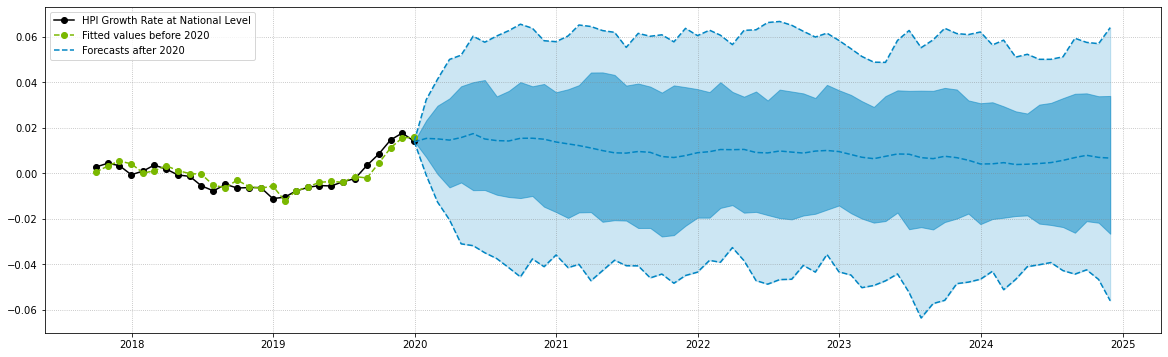

In [271]:

color1 = "#0085c3"
color2 = "#7ab800"
color3 = "#dc5034"
# y = df_results["forecast"]
# y2 = df_test["l0"][-nobs:]
# y = inversed_list

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)


ax.plot(df_plot2['date'], df_plot2['l0'], marker="o", color = "#000000",label="HPI Growth Rate at National Level")
ax.plot(
   df_plot2['date'], df_plot2['l0_pred'], marker="o", ls="--", color=color2, label="Fitted values before 2020"
)



ax.plot(df_plot2['date'],df_plot2['Ubound'], color=color1,ls='--')
ax.plot(df_plot2['date'],df_plot2['Lbound'] , color=color1,ls='--')
ax.fill_between(df_plot2['date'],df_plot2['Ubound'],df_plot2['Lbound'], color = color1,alpha=0.2)
ax.fill_between(df_plot2['date'],df_plot2['Ubound2'],df_plot2['Lbound2'],  color = color1, alpha=0.5)
ax.plot(
   df_plot2['date'], df_plot2['mean'], ls="--", color=color1, label="Forecasts after 2020"
)
ax.grid(ls=':', color='gray', alpha=0.6)
ax.legend(loc='upper left', fontsize=10)

ax.set_xlabel("")


In [255]:
df_plot2['date'].values

array(['2017-09-30T00:00:00.000000000', '2017-10-31T00:00:00.000000000',
       '2017-11-30T00:00:00.000000000', '2017-12-31T00:00:00.000000000',
       '2018-01-31T00:00:00.000000000', '2018-02-28T00:00:00.000000000',
       '2018-03-31T00:00:00.000000000', '2018-04-30T00:00:00.000000000',
       '2018-05-31T00:00:00.000000000', '2018-06-30T00:00:00.000000000',
       '2018-07-31T00:00:00.000000000', '2018-08-31T00:00:00.000000000',
       '2018-09-30T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-11-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000',
       '2019-01-31T00:00:00.000000000', '2019-02-28T00:00:00.000000000',
       '2019-03-31T00:00:00.000000000', '2019-04-30T00:00:00.000000000',
       '2019-05-31T00:00:00.000000000', '2019-06-30T00:00:00.000000000',
       '2019-07-31T00:00:00.000000000', '2019-08-31T00:00:00.000000000',
       '2019-09-30T00:00:00.000000000', '2019-10-31T00:00:00.000000000',
       '2019-11-30T00:00:00.000000000', '2019-12-31

In [164]:
agg["date"].loc[("2020-01" > agg["date"]) & (agg["date"] > "2001-01")]

13    2001-01-31
14    2001-02-28
15    2001-03-31
16    2001-04-30
17    2001-05-31
         ...    
236   2019-08-31
237   2019-09-30
238   2019-10-31
239   2019-11-30
240   2019-12-31
Name: date, Length: 228, dtype: datetime64[ns]

In [35]:
avg_1_pred = pd.DataFrame(inversed_list, columns=["l0_forecast"])
avg_1_pred['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2001-01")].reset_index(drop= True)["date"]    
avg_1_pred  = avg_1_pred.set_index("date")


In [36]:
lst_whole = list(dfHILDA.columns)
result_ancob = [i for i in lst_whole if i.startswith('ancob_')]
list_ancob0 = ['1101', '2100', '1201', '7103', '5204', '6101', '9225', '5105', '2308']
list_ancob =  ['ancob_' + sub for sub in list_ancob0]
result_edhigh = [i for i in lst_whole if i.startswith('edhigh1_')]
list_edhigh0= ['1','2','3','4','5','8','9']
list_edhigh =  ['edhigh1_' + sub for sub in list_edhigh0]
result_anatsi = [i for i in lst_whole if i.startswith('anatsi_')]
list_anatsi0= ['1','2','3','4']
list_anatsi =  ['anatsi_' + sub for sub in list_anatsi0]
result_chkb =  [i for i in lst_whole if i.startswith('chkb12_')]
list_chkb0= ['1','2','3','4']
list_chkb =  ['chkb12_' + sub for sub in list_chkb0]
list_deleted =  [i for i in lst_whole if i.startswith(('ancob_','edhigh1_','chkb12_','anatsi_'))]
list_remained = [vn for vn in lst_whole if vn not in list_deleted]
list_final = list_remained + list_ancob + list_edhigh + list_anatsi + list_chkb

In [37]:
def gamma2AIC_VAR(key,pcafit,d3,lag):
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  
    
    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    
    
    df1 = pd.concat([pcadf,avg_1['l0']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
#     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")
    df4['l1'] = df4['l01'] - df4['l0']
    pcadf_sa4_date_new = df4.drop(['l01', 'l0'], axis=1)

    modelsa4 = VAR(pcadf_sa4_date_new)
    result = modelsa4.fit(lag)
    #print("Lag Order =", lag)
    #print("AIC : ", result.aic)
    return(result.aic)

In [38]:
def gamma2pre_VAR(key,pcafit,d3,lag):
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  
    
    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    
    
    df1 = pd.concat([pcadf,avg_1['l0']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
#     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")
    df4['l1'] = df4['l01'] - df4['l0']
    pcadf_sa4_date_new = df4.drop(['l01', 'l0'], axis=1)
    pcadf_sa4_date_new = pcadf_sa4_date_new.reset_index() 
    df5= pcadf_sa4_date_new.loc[("2020-01" >pcadf_sa4_date_new["date"])&(pcadf_sa4_date_new["date"]> "2000-12")].reset_index(drop = True)
    df = df5.iloc[:,1:]

    modelsa4 = VAR(df)
    model_fitted = modelsa4.fit(lag)
    
    lag_order = model_fitted.k_ar
    forecast_input = df
    start_point = lag_order 

    df_forecast = []
    for i in range(1,df.shape[0]-lag_order+1, 1):
        forecast_input = df.values[
            -lag_order + start_point + i - 1 : start_point + i - 1,
        ]
        df_forecast.append(
            model_fitted.forecast(y=forecast_input, steps=1)[
                0,
            ][-1]
        )
    avg_3_pred_sa4 = pd.DataFrame(df_forecast, columns=["l1_forecast"])
    #print("Lag Order =", lag)
    #print("AIC : ", result.aic)
    return(avg_3_pred_sa4)

In [39]:
def gamma2rf(key,pcafit,d3,lag):
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  
    
    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    
    #print("Lag Order =", lag)
    #print("AIC : ", result.aic)
    return(pcadf)

In [40]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

gamma_order = -1
lag_list = [0,1,2,3,4,5,6,7,8]
aic_array = np.zeros((len(gammaList), len(lag_list)) )
count_array = np.zeros((len(gammaList), len(lag_list)))
for gamma1 in gammaList:
    gamma_order = gamma_order+1
    d3_0, pcafit_0 = PCA_val(gamma1,df_marks,vrdata)
    for lag0 in lag_list:
        count = 0
        AICtotal = 0
        #print('Initial_count: ', count)
        for key in DataFrameDict_Hsa4.keys():    
            try:
                #print(key)
                AICtotal = AICtotal+gamma2AIC_VAR(key, pcafit_0, d3_0, lag0)
                count = count+1
            except:
                #print(AICtotal)
                pass
            
        avg =  AICtotal/count 
        PCnum = 12 - gamma_order
        
        print('PCnum: ', PCnum)
        print('lag: ',lag0)
        print('count: ',count)
        
        count_array[gamma_order][lag0] = count
#         print('avgAIC: ', avg )
        aic_array[gamma_order][lag0] = avg


PCnum:  12
lag:  0
count:  73
PCnum:  12
lag:  1
count:  75
PCnum:  12
lag:  2
count:  72
PCnum:  12
lag:  3
count:  73
PCnum:  12
lag:  4
count:  73
PCnum:  12
lag:  5
count:  71
PCnum:  12
lag:  6
count:  71
PCnum:  12
lag:  7
count:  75
PCnum:  12
lag:  8
count:  69
PCnum:  11
lag:  0
count:  84
PCnum:  11
lag:  1
count:  82
PCnum:  11
lag:  2
count:  81
PCnum:  11
lag:  3
count:  84
PCnum:  11
lag:  4
count:  81
PCnum:  11
lag:  5
count:  83
PCnum:  11
lag:  6
count:  83
PCnum:  11
lag:  7
count:  84
PCnum:  11
lag:  8
count:  84
PCnum:  10
lag:  0
count:  87
PCnum:  10
lag:  1
count:  87
PCnum:  10
lag:  2
count:  87
PCnum:  10
lag:  3
count:  87
PCnum:  10
lag:  4
count:  87
PCnum:  10
lag:  5
count:  87
PCnum:  10
lag:  6
count:  87
PCnum:  10
lag:  7
count:  87
PCnum:  10
lag:  8
count:  87
PCnum:  9
lag:  0
count:  87
PCnum:  9
lag:  1
count:  87
PCnum:  9
lag:  2
count:  87
PCnum:  9
lag:  3
count:  87
PCnum:  9
lag:  4
count:  87
PCnum:  9
lag:  5
count:  87
PCnum:  9
lag:  

In [41]:
a2l.to_ltx(count_array)

\begin{bmatrix}
  73.00 &  75.00 &  72.00 &  73.00 &  73.00 &  71.00 &  71.00 &  75.00 &  69.00\\
  84.00 &  82.00 &  81.00 &  84.00 &  81.00 &  83.00 &  83.00 &  84.00 &  84.00\\
  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00\\
  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00\\
  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00\\
  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00 &  87.00
\end{bmatrix}


In [42]:
a2l.to_ltx(aic_array)

\begin{bmatrix}
 -29.40 & -59.70 & -56.73 & -55.31 & -55.16 & -52.01 & -50.87 & -52.58 & -47.38\\
 -23.81 & -49.55 & -47.89 & -48.26 & -45.96 & -45.86 & -44.61 & -43.39 & -42.78\\
 -18.98 & -43.28 & -42.39 & -41.51 & -40.63 & -39.76 & -38.92 & -38.11 & -37.38\\
 -17.25 & -39.31 & -38.59 & -37.87 & -37.15 & -36.44 & -35.74 & -35.07 & -34.45\\
 -15.53 & -35.35 & -34.78 & -34.20 & -33.62 & -33.04 & -32.48 & -31.93 & -31.43\\
 -13.15 & -30.66 & -30.22 & -29.77 & -29.31 & -28.86 & -28.42 & -27.99 & -27.58
\end{bmatrix}


In [43]:
gammaList[2]

5.050505050505051

In [44]:
import statsmodels.api as statm
from statistics import mean
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
gamma_final = gammaList[2]
d3_final, pcafit_final = PCA_val(gamma_final,df_marks,vrdata)
lag_final = 1

In [45]:
avg_3_pred_values= []
lst = ["date","sa4", "l0_fc", "l1_fc", "l01_fc"]
# Calling DataFrame constructor on list
for key in DataFrameDict_Hsa4.keys():    
    try:
        df = pd.DataFrame([], columns=lst)
        df1 = avg_1_pred.reset_index()
        df["date"] = df1["date"].loc[("2020-01" >df1["date"])& (df1["date"] > "1999-12")]
        df["sa4"] = key 
        df["l0_fc"] = df1["l0_forecast"].loc[("2020-01" >df1["date"])& (df1["date"] > "1999-12")]
        df["l1_fc"] = gamma2pre_VAR(key, pcafit_final, d3_final, lag_final)["l1_forecast"]
        df["l01_fc"]  = df["l0_fc"] + df["l1_fc"]
        avg_3_pred_values.append(df)
        
    except:
        pass
    


avg_3_pred = pd.concat(avg_3_pred_values)
avg_3_pred = avg_3_pred.reset_index(drop=True)
avg_3_pred['date'] = pd.to_datetime(avg_3_pred['date'],errors = 'coerce')
    

In [46]:
avg_3_pred = avg_3_pred.drop(['l0_fc', 'l1_fc'], axis=1)    

In [47]:
Rsq = []
postcode_list_OLS = []
sa4_list_OLS = []
for key in DataFrameDict_postcode.keys():
    try:
        df = pd.DataFrame([])
        sa4_name =  DataFrameDict_postcode[key]["sa4_name16"].unique()[0]
        df_rf_sa4 = gamma2rf(sa4_name,pcafit_final,d3_final,lag_final)
        df_rf_nat = PC_nat
        df1 = df_rf_nat.join(df_rf_sa4)
        df2 = df1.join(avg_4.loc[avg_4['postcode'] == key].set_index('date'))
        df3 = df2.join(avg_3.loc[avg_3['sa4'] == sa4_name].set_index('date'))
        df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
        df4['l2'] = df4['l012'] - df4['l01']
        df5 = df4.drop(['postcode','sa4','l012', 'l01'], axis=1)    
        df6 = df1.interpolate("bfill").interpolate("ffill").reset_index()
        df6['date'] = df6['date'].astype(str)
        month = [int(my_str.split("-")[1]) for my_str in df6["date"].values]
        quater = [(m - 1) // 3 + 1 for m in month]
        monthdummies = pd.get_dummies(month, prefix="month").iloc[:,:-1]
        quaterdummies = pd.get_dummies(quater, prefix="quater").iloc[:,:-1]
        dummies = pd.concat([monthdummies, quaterdummies], axis=1)
        df7 =  pd.concat([df6,dummies],axis =1)
        X = df7.iloc[:, 1:].values
        y = df5.iloc[:, -1].values
        
#         result = statm.OLS(y, X).fit()
        result = statm.OLS(y, X).fit()
        Rsq.append(result.rsquared)
        sa4_list_OLS.append(sa4_name)
        postcode_list_OLS.append(key)
        
    except:
        print(key)
        print(sa4_name)
        pass
        
cleanedRsq = [x for x in Rsq if str(x) != "nan"]
mean(cleanedRsq)   


4670
Wide Bay
4655
Wide Bay
4650
Wide Bay
4615
Wide Bay


0.11998853082572587

In [48]:
print(sa4_list_OLS[cleanedRsq.index(max(cleanedRsq))])
print(cleanedRsq[cleanedRsq.index(max(cleanedRsq))])

Mackay - Isaac - Whitsunday
0.29805862984370357


# Map


In [49]:
postcodecsv = pd.read_csv("au_postcodes.csv")
# References:
# https://blog.greglow.com/2019/11/05/power-bi-creating-a-topojson-file-of-australian-postcodes-for-use-with-shape-map/
# https://mapshaper.org/
# https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.003July%202016?OpenDocument

from statistics import mean, median

import pandas as pd
from scipy import stats

ndf = pd.read_json("POA_2016_AUST.json")
ndf1 = ndf["features"].apply(pd.Series)
ndf2 = ndf1["geometry"].apply(pd.Series)
ndf3 = ndf1["properties"].apply(pd.Series)
border = ndf2["coordinates"]

depth = lambda L: isinstance(L, list) and max(map(depth, L)) + 1


def flatten(d, l=1):
    for i in d:
        yield from ([i] if l == 1 else flatten(i, l - 1))


def centerlocation(index):
    tmplst = list(flatten(border[index], l=depth(border[index])))
    longi = median([i for i in tmplst if i > 0])
    lati = median([i for i in tmplst if i < 0])
    return [longi, lati]


postcodedf = []
i = 0
for i in range(len(ndf)):
    if depth(border[i]) > 0:
        tpd = {
            "postcode": [ndf3["POA_CODE16"].iloc[i]],
            "longitude": [centerlocation(i)[0]],
            "latitude": [centerlocation(i)[1]],
        }
        tpdf = pd.DataFrame(tpd)
        postcodedf.append(tpdf)
    else:
        print(i)
        continue
    i = i + 1
postcodedf = pd.concat(postcodedf, ignore_index=True)

2668
2669


In [50]:
import pandas as pd
import pdfkit as pdf
import sqlite3
import numpy as np


# df = residuals_OLS
# df.to_html('f.html')
# nazivFajla='z.pdf'
# pdf.from_file('f.html', nazivFajla)

In [51]:
DataFrameDict_results1 = {elem: pd.DataFrame for elem in DataFrameDict_postcode.keys()}
for key in DataFrameDict_results1.keys():
    try:
        if sum(postcodedf["postcode"] == key) > 0:
            # ind = placepc.loc[placepc == pc].index[0]
            ind = postcodedf.loc[postcodedf["postcode"] == key].index[0]
            df = DataFrameDict_postcode[key]
            if len(df["Hedonic Home Value Index"]) > 360:
                sa4_name =  DataFrameDict_postcode[key]["sa4_name16"].unique()[0]
                df_rf_sa4 = gamma2rf(sa4_name,pcafit_final,d3_final,lag_final)
                df_rf_nat = PC_nat
                df1 = df_rf_nat.join(df_rf_sa4)
                df2 = df1.join(avg_4.loc[avg_4['postcode'] == key].set_index('date'))
                df3 = df2.join(avg_3_pred.loc[avg_3_pred['sa4'] ==sa4_name].set_index('date'))
                df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
                df4['l2'] = df4['l012'] - df4['l01_fc']
                df5 = df4.drop(['postcode','sa4','l012', 'l01_fc'], axis=1)    
                df6 = df1.interpolate("bfill").interpolate("ffill").reset_index()
                df6['date'] = df6['date'].astype(str)
                month = [int(my_str.split("-")[1]) for my_str in df6["date"].values]
                quater = [(m - 1) // 3 + 1 for m in month]
                monthdummies = pd.get_dummies(month, prefix="month").iloc[:,:-1]
                quaterdummies = pd.get_dummies(quater, prefix="quater").iloc[:,:-1]
                dummies = pd.concat([monthdummies, quaterdummies], axis=1)
                df7 =  pd.concat([df6,dummies],axis =1)
                X = df7.iloc[:, 1:].values
                y = df5.iloc[:, -1].values
                result = statm.OLS(y, X).fit()
                predicted =  df4['l01_fc']+ result.predict(X)
                
                true_final_value = DataFrameDict_postcode[key].loc[DataFrameDict_postcode[key].value_at_date == "2019-11-30"]['Hedonic Home Value Index']
                predicted_final_value = 2**(sum(predicted[-119:]))*100
                
                        # ind = placepc.loc[placepc == pc].index[0]
                ind = postcodedf.loc[postcodedf["postcode"] == key].index[0]
                tpd = {"l012": df4['l012'],
                    "l012_pred": predicted}
                tpdf = pd.DataFrame(tpd)
                tpdf['residuals'] = tpdf['l012_pred'] - tpdf['l012']
                DataFrameDict_results1[key] =  tpdf 
                

        else:
            print("area(value) %s: data incomplete" % (key))
            continue
    except:
        print(key)
        pass  

4670
4655
4650
4615


In [52]:
# with open('DataFrameDict_results1.pickle', 'wb') as f:
#      pickle.dump(DataFrameDict_results1, f)

/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_34749/1142463139.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  DF_simResults_l0['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-10")].reset_index(drop= True)["date"]
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_34749/1142463139.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  DF_simResults_l1['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-11")].reset_index(drop= True)["date"]
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/

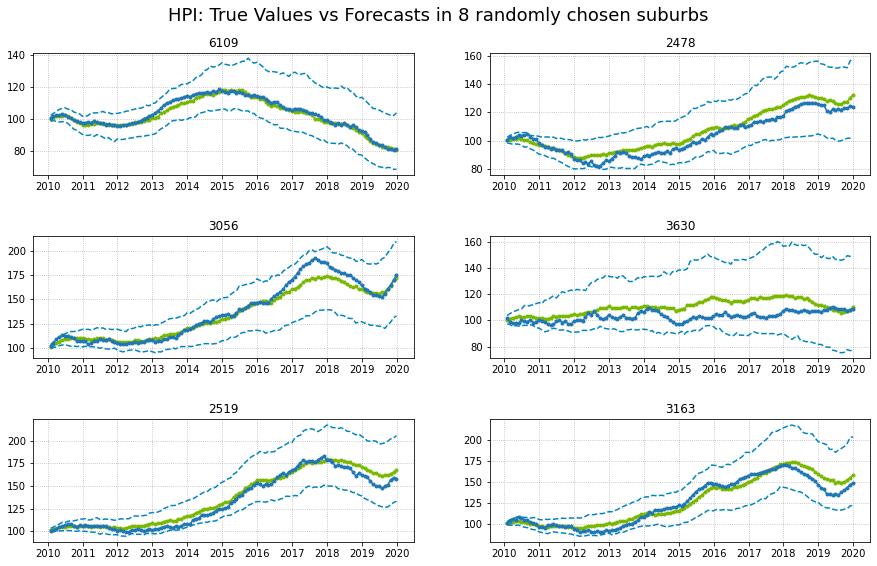

In [53]:
random.seed(111)
sim_times = 100

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
fig.suptitle("HPI: True Values vs Forecasts in 8 randomly chosen suburbs", fontsize=18, y=0.95)

plt.subplots_adjust(hspace=0.5)

color1 = '#0085c3'
color2 = '#7ab800'
color3 = '#dc5034'


mu, sigma = 0, 1 
df = pca_avg.iloc[:,1:]
model_fitted = model_fitted_l0
lag_order = lag_order_l0
start_point = start_point_l0


DF_simResults_l0 = pd.DataFrame({}, columns = ['l0'])

for t in range(1, sim_times):
    df_forecast_sim = pd.DataFrame({},columns=df.columns)
    df_forecast_sim = df_forecast_sim.append(pca_avg.iloc[ -123:-121,1: ]).reset_index(drop = True)
    for i in range(1,pca_avg.iloc[ -123:,1: ].shape[0]-lag_order+1, 1):
        forecast_input = pca_avg.values[-lag_order + start_point + i - 1 -123 : start_point + i - 1-123,1:]
        arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
        arr_noise = np.random.normal(mu, sigma, len(df.columns))
        arr_new = np.add(arr_pred,arr_noise)
        df_new =  pd.DataFrame( arr_new ,columns=df.columns )
        df_forecast_sim = df_forecast_sim.append(df_new)
        df_forecast_sim = df_forecast_sim.reset_index(drop = True)
    DF_simResults_l0 = DF_simResults_l0.join(df_forecast_sim['l0'], how='right', rsuffix = f'_sim{t}')
    
DF_simResults_l0['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-10")].reset_index(drop= True)["date"] 
DF_simResults_l0.set_index("date", inplace = True)
DF_simResults_l0.drop(labels='l0', axis=1, inplace=True)
DF_simResults_l0 = pd.DataFrame(scaler1.inverse_transform(DF_simResults_l0.values), index = DF_simResults_l0.index, columns =   DF_simResults_l0.columns)
        
    
for ax in axs.ravel():
    keypostcode = random.choice(tuple(DataFrameDict_postcode.keys()))
    keysa4 = DataFrameDict_postcode[keypostcode]["sa4_name16"].loc[
        (DataFrameDict_postcode[keypostcode]["postcode"] == keypostcode)].unique()[0]



    key = keysa4
    d3= d3_final
    pcafit = pcafit_final
    gamma = gamma_final
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

    # X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  

    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    

    df1 = pd.concat([pcadf,avg_1_pred['l0_forecast']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
    #     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")



    values  = (df4['l01'] - df4['l0_forecast']).values
    values = values.reshape((len(values), 1))

    scaler2 = scaler.fit(values)
    normalized  = scaler2.transform(values)
    normalized_list =  [i[0] for i in normalized]

    df4['l1'] = normalized_list


    pcadf_sa4_date_new = df4.drop(['l01', 'l0_forecast'], axis=1)
    pcadf_sa4_date_new = pcadf_sa4_date_new.reset_index() 
    df5= pcadf_sa4_date_new.loc[("2020-01" >pcadf_sa4_date_new["date"])&(pcadf_sa4_date_new["date"]> "2000-12")].reset_index(drop = True)
    df = df5.iloc[:,1:]


    modelsa4 = VAR(df)
    model_fitted_l1 = modelsa4.fit(lag_final)
    df_example = df
    lag_order_l1 =  lag_final
    start_point_l1 = lag_final


    model_fitted = model_fitted_l1 
    df = df_example
    lag_order = lag_order_l1
    start_point = start_point_l1 

    DF_simResults_l1 = pd.DataFrame({}, columns = ['l1'])

    for t in range(1, sim_times):
        df_forecast_sim = pd.DataFrame({},columns=df.columns)
        df_forecast_sim = df_forecast_sim.append(df.iloc[-121:-119, ])
        for i in range(1,df.iloc[-121:, ].shape[0]-lag_order+1, 1):
            forecast_input = df.values[-lag_order + start_point + i - 1 -121: start_point + i - 1-121,]
            arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
            arr_noise = np.random.normal(mu, sigma, len(df.columns))
            arr_new = np.add(arr_pred,arr_noise)
            df_new =  pd.DataFrame( arr_new ,columns=df.columns )
            df_forecast_sim = df_forecast_sim.append(df_new)
            df_forecast_sim = df_forecast_sim.reset_index(drop = True)
        DF_simResults_l1 = DF_simResults_l1.join(df_forecast_sim['l1'], how='right', rsuffix = f'_sim{t}')
    DF_simResults_l1['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-11")].reset_index(drop= True)["date"] 
    DF_simResults_l1.set_index("date", inplace = True)
    DF_simResults_l1.drop(labels='l1', axis=1, inplace=True)

    DF_simResults_l1 = pd.DataFrame(scaler2.inverse_transform(DF_simResults_l1.values), index = DF_simResults_l1.index, columns =   DF_simResults_l0.columns)

    key = keypostcode
    ind = postcodedf.loc[postcodedf["postcode"] == key].index[0]
    df = DataFrameDict_postcode[key]

    z_critical = stats.norm.ppf(q = 0.95) 



    if len(df["Hedonic Home Value Index"]) > 360:
        sa4_name =  DataFrameDict_postcode[key]["sa4_name16"].unique()[0]
        df_rf_sa4 = gamma2rf(sa4_name,pcafit_final,d3_final,lag_final)
        df_rf_nat = PC_nat
        df1 = df_rf_nat.join(df_rf_sa4)
        df2 = df1.join(avg_4.loc[avg_4['postcode'] == key].set_index('date'))
        df3 = df2.join(avg_3.loc[avg_3['sa4'] ==sa4_name].set_index('date'))
        df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
        df4['l2'] = df4['l012'] - df4['l01']
        df5 = df4.drop(['postcode','sa4','l012', 'l01'], axis=1)    
        df6 = df1.interpolate("bfill").interpolate("ffill").reset_index()
        df6['date'] = df6['date'].astype(str)
        month = [int(my_str.split("-")[1]) for my_str in df6["date"].values]
        quater = [(m - 1) // 3 + 1 for m in month]
        monthdummies = pd.get_dummies(month, prefix="month").iloc[:,:-1]
        quaterdummies = pd.get_dummies(quater, prefix="quater").iloc[:,:-1]
        dummies = pd.concat([monthdummies, quaterdummies], axis=1)
        df7 =  pd.concat([df6,dummies],axis =1)
        X = df7.iloc[:, 1:].values
        y = df5.iloc[:, -1].values
        result = statm.OLS(y, X).fit()

        sim_res_example = pd.DataFrame({} ) 
        for t in range(0,sim_times-1):
            predicted =  DF_simResults_l0.iloc[3:,t]+ DF_simResults_l1.iloc[2:,t]+ result.predict(X)[-120:] 
            df1 = pd.DataFrame(np.cumsum(predicted.values),columns = ['l012_sim'],index =predicted.index )
            sim_res_example = sim_res_example.join(df1['l012_sim'], how='right', rsuffix = f'_{t}') 
            sim_res_example['mean'] =  sim_res_example.quantile(0.5,axis = 1)
            sim_res_example['stdev'] = sim_res_example.std(axis=1)
            sim_res_example['moe'] = z_critical * (sim_res_example['stdev']/math.sqrt(sim_times))
            sim_res_example['Ubound'] = sim_res_example.quantile(0.95,axis = 1)
            sim_res_example['Lbound'] = sim_res_example.quantile(0.05,axis = 1)


        #         sim_res_example['Lbound'] = sim_res_example['mean'] + sim_res_example['moe']         
        #         sim_res_example['Lbound'] = sim_res_example['mean'] - sim_res_example['moe'] 

    df_final = 2**sim_res_example*100    



#     fig = plt.figure(figsize=(8,6))
#     ax = fig.add_subplot(111)


    df1 =  sim_res_example.reset_index()
    x1 = df1['date'].values
    df2 = DataFrameDict_postcode[key].loc[(DataFrameDict_postcode[key]['value_at_date']>'2009-12-31')&(DataFrameDict_postcode[key]['value_at_date']<'2020-01-01')]
    x2= df2['value_at_date'].values

    ax.plot(x1,df_final['mean'] , color=color2, marker='.', label='HPI Forecasts')
    ax.plot(x1,df_final['Ubound'], color=color1,ls='--')
    ax.plot(x1, df_final['Lbound'] , color=color1,ls='--')
    ax.plot(x1, df2['Hedonic Home Value Index'] ,marker='.',label = 'HPI')
    ax.grid(ls=':', color='gray', alpha=0.6)
#     ax.legend(loc='upper left', fontsize=10)
    ax.set_title(keypostcode.upper())
    ax.set_xlabel("")



    
                                                                                  

/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_34749/2858406170.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  DF_simResults_l0['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-10")].reset_index(drop= True)["date"]
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_34749/2858406170.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  DF_simResults_l1['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-11")].reset_index(drop= True)["date"]
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/

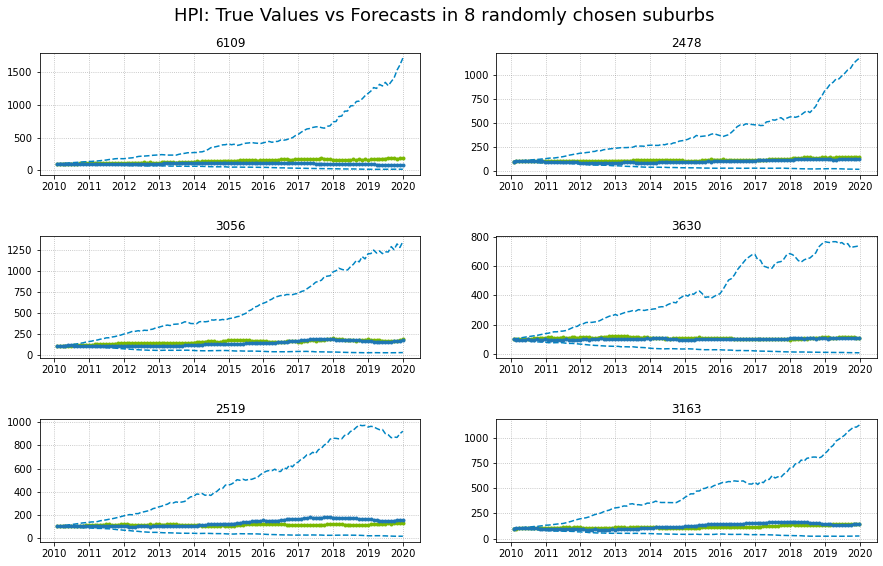

In [54]:
random.seed(111)
sim_times = 100

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
fig.suptitle("HPI: True Values vs Forecasts in 8 randomly chosen suburbs", fontsize=18, y=0.95)

plt.subplots_adjust(hspace=0.5)

color1 = '#0085c3'
color2 = '#7ab800'
color3 = '#dc5034'


mu, sigma = 0, 1 
df = pca_avg.iloc[:,1:]
model_fitted = model_fitted_l0
lag_order = lag_order_l0
start_point = start_point_l0




DF_simResults_l0 = pd.DataFrame({}, columns = ['l0'])


for t in range(1, sim_times):
    df_forecast_sim = pd.DataFrame({},columns=df.columns)
    df_forecast_sim = df_forecast_sim.append(pca_avg.iloc[ -123:-121,1: ]).reset_index(drop = True)
    for i in range(1,pca_avg.iloc[ -123:,1: ].shape[0]-lag_order+1, 1):
        forecast_input = df_forecast_sim.values[-lag_order + start_point + i - 1 : start_point + i - 1,]
        arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
        arr_noise = np.random.normal(mu, sigma, len(df.columns))
        arr_new = np.add(arr_pred,arr_noise)
        df_new =  pd.DataFrame( arr_new ,columns=df.columns )
        df_forecast_sim = df_forecast_sim.append(df_new)
        df_forecast_sim = df_forecast_sim.reset_index(drop = True)
    DF_simResults_l0 = DF_simResults_l0.join(df_forecast_sim['l0'], how='right', rsuffix = f'_sim{t}')
    
DF_simResults_l0['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-10")].reset_index(drop= True)["date"] 
DF_simResults_l0.set_index("date", inplace = True)
DF_simResults_l0.drop(labels='l0', axis=1, inplace=True)

DF_simResults_l0 = pd.DataFrame(scaler1.inverse_transform(DF_simResults_l0.values), index = DF_simResults_l0.index, columns =   DF_simResults_l0.columns)

    
for ax in axs.ravel():
    keypostcode = random.choice(tuple(DataFrameDict_postcode.keys()))
    keysa4 = DataFrameDict_postcode[keypostcode]["sa4_name16"].loc[
        (DataFrameDict_postcode[keypostcode]["postcode"] == keypostcode)].unique()[0]



    key = keysa4
    d3= d3_final
    pcafit = pcafit_final
    gamma = gamma_final
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

    # X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  

    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    

    df1 = pd.concat([pcadf,avg_1_pred['l0_forecast']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
    #     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")



    values  = (df4['l01'] - df4['l0_forecast']).values
    values = values.reshape((len(values), 1))

    scaler2 = scaler.fit(values)
    normalized  = scaler2.transform(values)
    normalized_list =  [i[0] for i in normalized]

    df4['l1'] = normalized_list


    pcadf_sa4_date_new = df4.drop(['l01', 'l0_forecast'], axis=1)
    pcadf_sa4_date_new = pcadf_sa4_date_new.reset_index() 
    df5= pcadf_sa4_date_new.loc[("2020-01" >pcadf_sa4_date_new["date"])&(pcadf_sa4_date_new["date"]> "2000-12")].reset_index(drop = True)
    df = df5.iloc[:,1:]


    modelsa4 = VAR(df)
    model_fitted_l1 = modelsa4.fit(lag_final)
    df_example = df
    lag_order_l1 =  lag_final
    start_point_l1 = lag_final


    model_fitted = model_fitted_l1 
    df = df_example
    lag_order = lag_order_l1
    start_point = start_point_l1 

    DF_simResults_l1 = pd.DataFrame({}, columns = ['l1'])

    for t in range(1, sim_times):
        df_forecast_sim = pd.DataFrame({},columns=df.columns)
        df_forecast_sim = df_forecast_sim.append(df.iloc[-121:-119, ])
        for i in range(1,df.iloc[-121:, ].shape[0]-lag_order+1, 1):
            forecast_input = df_forecast_sim.values[-lag_order + start_point + i - 1 : start_point + i - 1,]
            arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
            arr_noise = np.random.normal(mu, sigma, len(df.columns))
            arr_new = np.add(arr_pred,arr_noise)
            df_new =  pd.DataFrame( arr_new ,columns=df.columns )
            df_forecast_sim = df_forecast_sim.append(df_new)
            df_forecast_sim = df_forecast_sim.reset_index(drop = True)
        DF_simResults_l1 = DF_simResults_l1.join(df_forecast_sim['l1'], how='right', rsuffix = f'_sim{t}')
    DF_simResults_l1['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-11")].reset_index(drop= True)["date"] 
    DF_simResults_l1.set_index("date", inplace = True)
    DF_simResults_l1.drop(labels='l1', axis=1, inplace=True)

    DF_simResults_l1 = pd.DataFrame(scaler2.inverse_transform(DF_simResults_l1.values), index = DF_simResults_l1.index, columns =   DF_simResults_l0.columns)

    key = keypostcode
    ind = postcodedf.loc[postcodedf["postcode"] == key].index[0]
    df = DataFrameDict_postcode[key]

    z_critical = stats.norm.ppf(q = 0.95) 



    if len(df["Hedonic Home Value Index"]) > 360:
        sa4_name =  DataFrameDict_postcode[key]["sa4_name16"].unique()[0]
        df_rf_sa4 = gamma2rf(sa4_name,pcafit_final,d3_final,lag_final)
        df_rf_nat = PC_nat
        df1 = df_rf_nat.join(df_rf_sa4)
        df2 = df1.join(avg_4.loc[avg_4['postcode'] == key].set_index('date'))
        df3 = df2.join(avg_3.loc[avg_3['sa4'] ==sa4_name].set_index('date'))
        df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
        df4['l2'] = df4['l012'] - df4['l01']
        df5 = df4.drop(['postcode','sa4','l012', 'l01'], axis=1)    
        df6 = df1.interpolate("bfill").interpolate("ffill").reset_index()
        df6['date'] = df6['date'].astype(str)
        month = [int(my_str.split("-")[1]) for my_str in df6["date"].values]
        quater = [(m - 1) // 3 + 1 for m in month]
        monthdummies = pd.get_dummies(month, prefix="month").iloc[:,:-1]
        quaterdummies = pd.get_dummies(quater, prefix="quater").iloc[:,:-1]
        dummies = pd.concat([monthdummies, quaterdummies], axis=1)
        df7 =  pd.concat([df6,dummies],axis =1)
        X = df7.iloc[:, 1:].values
        y = df5.iloc[:, -1].values
        result = statm.OLS(y, X).fit()

        sim_res_example = pd.DataFrame({} ) 
        for t in range(0,sim_times-1):
            predicted =  DF_simResults_l0.iloc[3:,t]+ DF_simResults_l1.iloc[2:,t]+ result.predict(X)[-120:] 
            df1 = pd.DataFrame(np.cumsum(predicted.values),columns = ['l012_sim'],index =predicted.index )
            sim_res_example = sim_res_example.join(df1['l012_sim'], how='right', rsuffix = f'_{t}') 
#             sim_res_example['mean'] =  sim_res_example.mean(axis=1)
            sim_res_example['mean'] =  sim_res_example.quantile(0.5,axis = 1)
            sim_res_example['stdev'] = sim_res_example.std(axis=1)
            sim_res_example['moe'] = z_critical * (sim_res_example['stdev']/math.sqrt(sim_times))
            sim_res_example['Ubound'] = sim_res_example.quantile(0.9,axis = 1)
            sim_res_example['Lbound'] = sim_res_example.quantile(0.1,axis = 1)


        #         sim_res_example['Lbound'] = sim_res_example['mean'] + sim_res_example['moe']         
        #         sim_res_example['Lbound'] = sim_res_example['mean'] - sim_res_example['moe'] 

    df_final = 2**sim_res_example*100    



#     fig = plt.figure(figsize=(8,6))
#     ax = fig.add_subplot(111)


    df1 =  sim_res_example.reset_index()
    x1 = df1['date'].values
    df2 = DataFrameDict_postcode[key].loc[(DataFrameDict_postcode[key]['value_at_date']>'2009-12-31')&(DataFrameDict_postcode[key]['value_at_date']<'2020-01-01')]
    x2= df2['value_at_date'].values

    ax.plot(x1,df_final['mean'] , color=color2, marker='.', label='HPI Forecasts')
    ax.plot(x1,df_final['Ubound'], color=color1,ls='--')
    ax.plot(x1, df_final['Lbound'] , color=color1,ls='--')
    ax.plot(x1, df2['Hedonic Home Value Index'] ,marker='.',label = 'HPI')
    ax.grid(ls=':', color='gray', alpha=0.6)
#     ax.legend(loc='upper left', fontsize=10)
    ax.set_title(keypostcode.upper())
    ax.set_xlabel("")



/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_34749/2986479134.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  DF_simResults_l0['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-10")].reset_index(drop= True)["date"]
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_34749/2986479134.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  DF_simResults_l1['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-11")].reset_index(drop= True)["date"]
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/

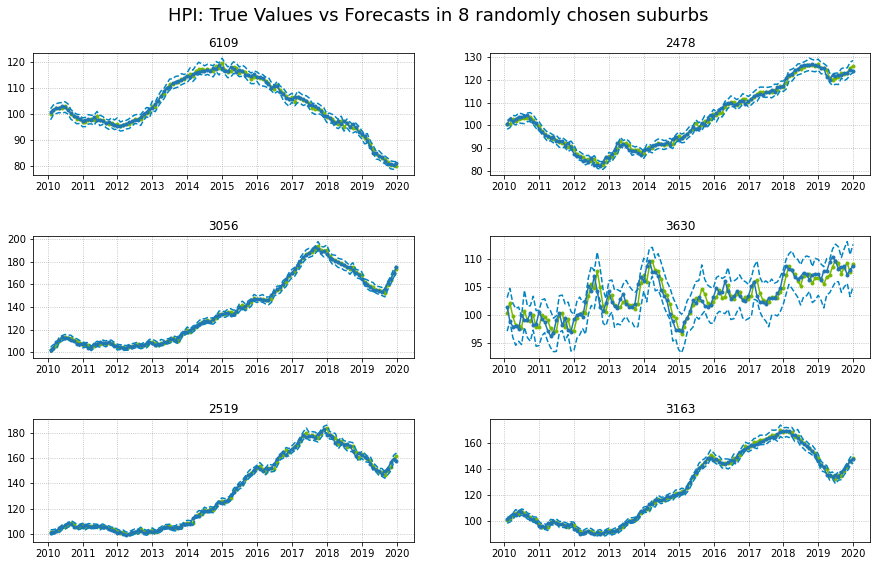

In [55]:
random.seed(111)
sim_times = 100

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
fig.suptitle("HPI: True Values vs Forecasts in 8 randomly chosen suburbs", fontsize=18, y=0.95)

plt.subplots_adjust(hspace=0.5)

color1 = '#0085c3'
color2 = '#7ab800'
color3 = '#dc5034'


mu, sigma = 0, 1 
df = pca_avg.iloc[:,1:]
model_fitted = model_fitted_l0
lag_order = lag_order_l0
start_point = start_point_l0




DF_simResults_l0 = pd.DataFrame({}, columns = ['l0'])

for t in range(1, sim_times):
    df_forecast_sim = pd.DataFrame({},columns=df.columns)
    df_forecast_sim = df_forecast_sim.append(pca_avg.iloc[ -123:-121,1: ]).reset_index(drop = True)
    for i in range(1,pca_avg.iloc[ -123:,1: ].shape[0]-lag_order+1, 1):
        forecast_input = pca_avg.values[-lag_order + start_point + i - 1 -123 : start_point + i - 1-123,1:]
        arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
        arr_noise = np.random.normal(mu, sigma, len(df.columns))
        arr_new = np.add(arr_pred,arr_noise)
        df_new =  pd.DataFrame( arr_new ,columns=df.columns )
        df_forecast_sim = df_forecast_sim.append(df_new)
        df_forecast_sim = df_forecast_sim.reset_index(drop = True)
    DF_simResults_l0 = DF_simResults_l0.join(df_forecast_sim['l0'], how='right', rsuffix = f'_sim{t}')
    
DF_simResults_l0['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-10")].reset_index(drop= True)["date"] 
DF_simResults_l0.set_index("date", inplace = True)
DF_simResults_l0.drop(labels='l0', axis=1, inplace=True)
DF_simResults_l0 = pd.DataFrame(scaler1.inverse_transform(DF_simResults_l0.values), index = DF_simResults_l0.index, columns =   DF_simResults_l0.columns)
        
    
for ax in axs.ravel():
    keypostcode = random.choice(tuple(DataFrameDict_postcode.keys()))
    keysa4 = DataFrameDict_postcode[keypostcode]["sa4_name16"].loc[
        (DataFrameDict_postcode[keypostcode]["postcode"] == keypostcode)].unique()[0]



    key = keysa4
    d3= d3_final
    pcafit = pcafit_final
    gamma = gamma_final
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

    # X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  

    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    

    df1 = pd.concat([pcadf,avg_1_pred['l0_forecast']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
    #     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")



    values  = (df4['l01'] - df4['l0_forecast']).values
    values = values.reshape((len(values), 1))

    scaler2 = scaler.fit(values)
    normalized  = scaler2.transform(values)
    normalized_list =  [i[0] for i in normalized]

    df4['l1'] = normalized_list


    pcadf_sa4_date_new = df4.drop(['l01', 'l0_forecast'], axis=1)
    pcadf_sa4_date_new = pcadf_sa4_date_new.reset_index() 
    df5= pcadf_sa4_date_new.loc[("2020-01" >pcadf_sa4_date_new["date"])&(pcadf_sa4_date_new["date"]> "2000-12")].reset_index(drop = True)
    df = df5.iloc[:,1:]


    modelsa4 = VAR(df)
    model_fitted_l1 = modelsa4.fit(lag_final)
    df_example = df
    lag_order_l1 =  lag_final
    start_point_l1 = lag_final


    model_fitted = model_fitted_l1 
    df = df_example
    lag_order = lag_order_l1
    start_point = start_point_l1 

    DF_simResults_l1 = pd.DataFrame({}, columns = ['l1'])

    for t in range(1, sim_times):
        df_forecast_sim = pd.DataFrame({},columns=df.columns)
        df_forecast_sim = df_forecast_sim.append(df.iloc[-121:-119, ])
        for i in range(1,df.iloc[-121:, ].shape[0]-lag_order+1, 1):
            forecast_input = df.values[-lag_order + start_point + i - 1 -121: start_point + i - 1-121,]
            arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
            arr_noise = np.random.normal(mu, sigma, len(df.columns))
            arr_new = np.add(arr_pred,arr_noise)
            df_new =  pd.DataFrame( arr_new ,columns=df.columns )
            df_forecast_sim = df_forecast_sim.append(df_new)
            df_forecast_sim = df_forecast_sim.reset_index(drop = True)
        DF_simResults_l1 = DF_simResults_l1.join(df_forecast_sim['l1'], how='right', rsuffix = f'_sim{t}')
    DF_simResults_l1['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-11")].reset_index(drop= True)["date"] 
    DF_simResults_l1.set_index("date", inplace = True)
    DF_simResults_l1.drop(labels='l1', axis=1, inplace=True)

    DF_simResults_l1 = pd.DataFrame(scaler2.inverse_transform(DF_simResults_l1.values), index = DF_simResults_l1.index, columns =   DF_simResults_l0.columns)

    key = keypostcode
    ind = postcodedf.loc[postcodedf["postcode"] == key].index[0]
    df = DataFrameDict_postcode[key]

    z_critical = stats.norm.ppf(q = 0.95) 



    if len(df["Hedonic Home Value Index"]) > 360:
        sa4_name =  DataFrameDict_postcode[key]["sa4_name16"].unique()[0]
        df_rf_sa4 = gamma2rf(sa4_name,pcafit_final,d3_final,lag_final)
        df_rf_nat = PC_nat
        df1 = df_rf_nat.join(df_rf_sa4)
        df2 = df1.join(avg_4.loc[avg_4['postcode'] == key].set_index('date'))
        df3 = df2.join(avg_3.loc[avg_3['sa4'] ==sa4_name].set_index('date'))
        df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
        df4['l2'] = df4['l012'] - df4['l01']
        df5 = df4.drop(['postcode','sa4','l012', 'l01'], axis=1)    
        df6 = df1.interpolate("bfill").interpolate("ffill").reset_index()
        df6['date'] = df6['date'].astype(str)
        month = [int(my_str.split("-")[1]) for my_str in df6["date"].values]
        quater = [(m - 1) // 3 + 1 for m in month]
        monthdummies = pd.get_dummies(month, prefix="month").iloc[:,:-1]
        quaterdummies = pd.get_dummies(quater, prefix="quater").iloc[:,:-1]
        dummies = pd.concat([monthdummies, quaterdummies], axis=1)
        df7 =  pd.concat([df6,dummies],axis =1)
        X = df7.iloc[:, 1:].values
        y = df5.iloc[:, -1].values
        result = statm.OLS(y, X).fit()

        sim_res_example = pd.DataFrame({} ) 
        for t in range(0,sim_times-1):
            predicted =  DF_simResults_l0.iloc[3:,t]+ DF_simResults_l1.iloc[2:,t]+ result.predict(X)[-120:] 
            DfTrue =  DataFrameDict_postcode[key].loc[(DataFrameDict_postcode[key]['value_at_date']>'2009-11-30')&(DataFrameDict_postcode[key]['value_at_date']<'2019-12-31')]
            df1 = pd.DataFrame(predicted.values+np.log2(DfTrue['Hedonic Home Value Index'].values),columns = ['l012_sim'],index =predicted.index )
            sim_res_example = sim_res_example.join(df1['l012_sim'], how='right', rsuffix = f'_{t}') 
            sim_res_example['mean'] =  sim_res_example.quantile(0.5,axis = 1)
            sim_res_example['stdev'] = sim_res_example.std(axis=1)
            sim_res_example['moe'] = z_critical * (sim_res_example['stdev']/math.sqrt(sim_times))
            sim_res_example['Ubound'] = sim_res_example.quantile(0.95,axis = 1)
            sim_res_example['Lbound'] = sim_res_example.quantile(0.05,axis = 1)


        #         sim_res_example['Lbound'] = sim_res_example['mean'] + sim_res_example['moe']         
        #         sim_res_example['Lbound'] = sim_res_example['mean'] - sim_res_example['moe'] 

    df_final = 2**sim_res_example   



#     fig = plt.figure(figsize=(8,6))
#     ax = fig.add_subplot(111)


    df1 =  sim_res_example.reset_index()
    x1 = df1['date'].values
    df2 = DataFrameDict_postcode[key].loc[(DataFrameDict_postcode[key]['value_at_date']>'2009-12-31')&(DataFrameDict_postcode[key]['value_at_date']<'2020-01-01')]
    x2= df2['value_at_date'].values

    ax.plot(x1,df_final['mean'] , color=color2, marker='.', label='HPI Forecasts')
    ax.plot(x1,df_final['Ubound'], color=color1,ls='--')
    ax.plot(x1, df_final['Lbound'] , color=color1,ls='--')
    ax.plot(x1, df2['Hedonic Home Value Index'] ,marker='.',label = 'HPI')
    ax.grid(ls=':', color='gray', alpha=0.6)
#     ax.legend(loc='upper left', fontsize=10)
    ax.set_title(keypostcode.upper())
    ax.set_xlabel("")


